In [ ]:
import glob
import os
import shutil
import random
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import keras.utils as image
from tensorflow.keras import layers

In [10]:
import kagglehub
import pandas as pd
import os

dataset_path = kagglehub.dataset_download('bhavikjikadara/dog-and-cat-classification-dataset')
print('Data Source import completo.')

directory = os.path.join(dataset_path, 'PetImages')

images = []
labels = []

try:
  for foldr in os.listdir(directory):
    for filee in os.listdir(os.path.join(directory, foldr)):
      images.append(os.path.join(foldr, filee))
      labels.append(foldr)
        
except Exception as e:
  print(f'Error: {e}')

all_df = pd.DataFrame({
    'Images': images,
    'Labels': labels
    })

print(all_df)

Data Source import completo.
             Images Labels
0         Cat\0.jpg    Cat
1         Cat\1.jpg    Cat
2        Cat\10.jpg    Cat
3       Cat\100.jpg    Cat
4      Cat\1000.jpg    Cat
...             ...    ...
24993  Dog\9995.jpg    Dog
24994  Dog\9996.jpg    Dog
24995  Dog\9997.jpg    Dog
24996  Dog\9998.jpg    Dog
24997  Dog\9999.jpg    Dog

[24998 rows x 2 columns]


In [11]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['Labels'])
train_df

,Images,Labels
3548,Cat\1941.jpg,Cat
18640,Dog\4276.jpg,Dog
23090,Dog\8281.jpg,Dog
1289,Cat\11157.jpg,Cat
3940,Cat\2294.jpg,Cat
...,...,...
23893,Dog\9003.jpg,Dog
23456,Dog\8610.jpg,Dog
5251,Cat\3474.jpg,Cat
6826,Cat\4892.jpg,Cat


In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_df, test_df = train_test_split(all_df, test_size=0.2, random_state=42, stratify=all_df['Labels'])

print("Preparando o dataset de treino...")
trainimgen = ImageDataGenerator( 
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
    )

train_data = trainimgen.flow_from_dataframe(
    dataframe=train_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
)

print("Preparando o dataset de teste...")
testimgen = ImageDataGenerator()

test_data = testimgen.flow_from_dataframe(
    dataframe=test_df,
    directory=directory,
    x_col='Images',
    y_col='Labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=16,
    shuffle=False
)


Preparando o dataset de treino...
Found 19998 validated image filenames belonging to 2 classes.
Preparando o dataset de teste...
Found 5000 validated image filenames belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow import keras
import keras.utils as image
from tensorflow.keras import layers

# Criando o modelo Sequencial
model = keras.Sequential([
    # Input Layer e Data Augmentation
    layers.Input(shape=(224, 224, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),

    # Normalização dos pixels para a faixa [0, 1]
    layers.Rescaling(1./255),

    # Bloco Convolucional 1
    layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Bloco Convolucional 2
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Bloco Convolucional 3
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Achatamento (Flatten) para preparar para o classificador
    layers.Flatten(),

    # Camadas Densas (Classificador)
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.5), # Adicionando Dropout para regularização
    # Camada de Saída: 1 neurônio com ativação sigmoide para classificação binária
    layers.Dense(units=1, activation='sigmoid')
])

# Visualizar a arquitetura do modelo
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    25,690,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,714,721 (98.09 MB)

 Trainable params: 25,714,721 (98.09 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001), # Otimizador Adam é uma excelente escolha padrão
    loss=tf.keras.losses.BinaryCrossentropy(), # Loss para classificação binária com saída sigmoide
    metrics=['accuracy'] # Métrica para acompanhar durante o treino
)

In [ ]:
import tensorflow.keras.callbacks as cb

callbacky = cb.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=15,
    validation_data=test_data,
    callbacks=[callbacky]
)

Epoch 1/15
 182/1250 ━━━━━━━━━━━━━━━━━━━━ 10:06 567ms/step - accuracy: 0.5130 - loss: 0.8734

c:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Dogs vs Cats\.venv\Lib\site-packages\PIL\TiffImagePlugin.py:949: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 756s 602ms/step - accuracy: 0.6345 - loss: 0.6462 - val_accuracy: 0.7244 - val_loss: 0.5636
Epoch 2/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 733s 586ms/step - accuracy: 0.7096 - loss: 0.5680 - val_accuracy: 0.7576 - val_loss: 0.5048
Epoch 3/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 745s 596ms/step - accuracy: 0.7360 - loss: 0.5323 - val_accuracy: 0.7766 - val_loss: 0.4796
Epoch 4/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 728s 582ms/step - accuracy: 0.7553 - loss: 0.5060 - val_accuracy: 0.7972 - val_loss: 0.4440
Epoch 5/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 671s 536ms/step - accuracy: 0.7728 - loss: 0.4776 - val_accuracy: 0.7962 - val_loss: 0.4496
Epoch 6/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 546s 437ms/step - accuracy: 0.7828 - loss: 0.4666 - val_accuracy: 0.8018 - val_loss: 0.4397
Epoch 7/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 546s 437ms/step - accuracy: 0.7922 - loss: 0.4483 - val_accuracy: 0.8284 - val_loss: 0.3927
Epoch 8/15
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 549s 439ms/step - accuracy: 0.7

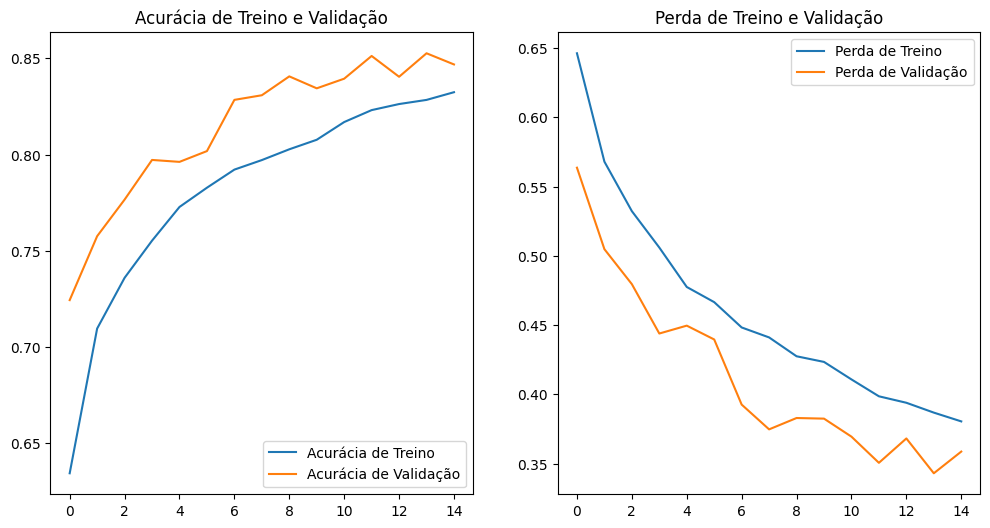

In [7]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Acurácia de Treino')
plt.plot(epochs_range, val_acc, label='Acurácia de Validação')
plt.legend(loc='lower right')
plt.title('Acurácia de Treino e Validação')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Perda de Treino')
plt.plot(epochs_range, val_loss, label='Perda de Validação')
plt.legend(loc='upper right')
plt.title('Perda de Treino e Validação')
plt.show()

In [10]:
model.evaluate(test_data)

313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - accuracy: 0.8468 - loss: 0.3587


[0.35874831676483154, 0.8468000292778015]

Fazendo previsões em todo o conjunto de validação...
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step

--- Relatório de Classificação ---
              precision    recall  f1-score   support

         Cat       0.91      0.77      0.83      2500
         Dog       0.80      0.92      0.86      2500

    accuracy                           0.85      5000
   macro avg       0.86      0.85      0.85      5000
weighted avg       0.86      0.85      0.85      5000


--- Matriz de Confusão ---
[[1923  577]
 [ 189 2311]]

     Previsto: Cat  | Previsto: Dog
Real: Cat |   1923     |   577  
Real: Dog |   189      |   2311 
--------------------------------

Exibindo alguns exemplos de previsões...


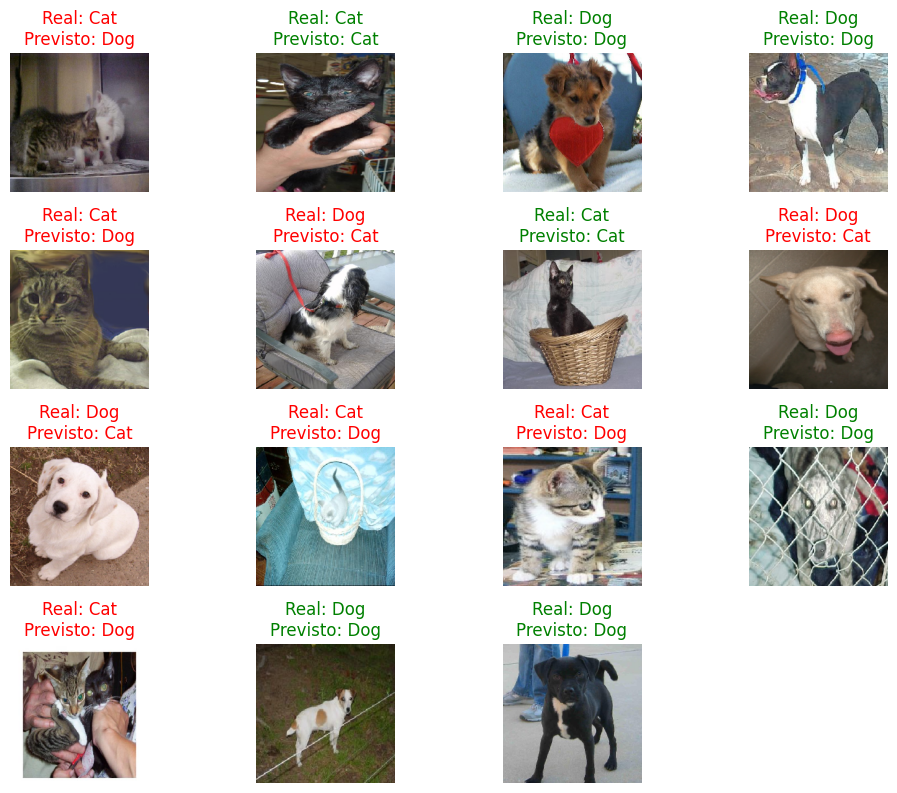

In [24]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Nomes das classes na ordem correta (geralmente alfabética)
CLASS_NAMES = ['Cat', 'Dog'] # Ou ['caes', 'gatos']

# --- 2. FAZER PREVISÕES E EXTRAIR RÓTULOS VERDADEIROS ---
print("Fazendo previsões em todo o conjunto de validação...")
# model.predict itera por todos os lotes do dataset e retorna um único array
predictions = model.predict(test_data)

# Extrai os rótulos verdadeiros do dataset
# Itera pelo dataset, pega os rótulos (y) de cada lote e os concatena
true_labels = test_data.labels

# Converte as previsões (probabilidades) em rótulos de classe (0 ou 1)
# Se a previsão > 0.5, a classe é 1 (Dog), senão é 0 (Cat)
predicted_labels = (predictions > 0.5).astype(int)

# --- 3. AVALIAÇÃO QUANTITATIVA ---
print("\n--- Relatório de Classificação ---")
# Mostra precisão, recall, f1-score para cada classe
print(classification_report(true_labels, predicted_labels, target_names=CLASS_NAMES))

print("\n--- Matriz de Confusão ---")
# Mostra quantos foram classificados corretamente e incorretamente
cm = confusion_matrix(true_labels, predicted_labels)
print(cm)
print("\n     Previsto: Cat  | Previsto: Dog")
print(f"Real: Cat |   {cm[0][0]:<5}    |   {cm[0][1]:<5}")
print(f"Real: Dog |   {cm[1][0]:<5}    |   {cm[1][1]:<5}")
print("--------------------------------")


# --- 4. VISUALIZAÇÃO DE EXEMPLOS ---
print("\nExibindo alguns exemplos de previsões...")

# MODIFICAÇÃO 1:
# Em vez de 'for ... in validation_dataset.take(1):'
# Nós usamos 'next()' para pegar o primeiro lote ANTES do loop.
try:
    images, labels = next(test_data)
except StopIteration:
    print("Erro: O gerador de validação está esgotado. Reinicie o script.")
    # Isso pode acontecer se você já iterou por ele (ex: no model.predict)
    # e precisa recriá-lo. Mas vamos tentar primeiro.

plt.figure(figsize=(10, 10))

# O loop 'for i in range(15)' agora está correto
for i in range(15): 
    # Garante que não vamos estourar o índice do lote
    if i >= len(images):
        break 
        
    ax = plt.subplot(5, 4, i + 1)
    
    # MODIFICAÇÃO 2: Removido o .numpy()
    # 'images' já é um array NumPy, então .numpy() não existe e não é necessário.
    # O Keras (antigo) retorna imagens como float, então convertemos para int.
    plt.imshow(images[i].astype("uint8"))
    
    # Pega o rótulo verdadeiro e o previsto para esta imagem
    
    # MODIFICAÇÃO 3: Removido o .numpy()
    # 'labels' também já é um array NumPy
    true_label_index = int(labels[i]) 
    
    # Esta linha está correta, assumingo que 'predicted_labels' foi
    # calculado antes e que shuffle=False foi usado.
    predicted_label_index = predicted_labels[i][0] 
    
    true_class_name = CLASS_NAMES[true_label_index]
    predicted_class_name = CLASS_NAMES[predicted_label_index]
    
    # Define o título e a cor (verde se acertou, vermelho se errou)
    title = f"Real: {true_class_name}\nPrevisto: {predicted_class_name}"
    color = "green" if true_label_index == predicted_label_index else "red"
    
    plt.title(title, color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
model.save(r'C:\Users\lucas\OneDrive - Amelyer Company\Documentos\Projetos Python\Dogs vs Cats\models\model_cnn.keras')